# Reparametrization

In [13]:
# generate data

import numpy as np

np.random.seed(1)
n, m = 300, 3
mu, sigma, kappa = 3, 0.01, 0.1

theta = np.random.normal(mu, sigma, n)
x = np.random.normal(theta, kappa, (m, n))

In [14]:
# define a statistical model

import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

numpyro.set_host_device_count(4) # 4スレッドで並列計算

def model(x):
      mu = numpyro.sample('mu', dist.Uniform(low=-100, high=100))
      sigma = numpyro.sample('sigma', dist.Uniform(low=0, high=100))
      kappa = numpyro.sample('kappa', dist.Uniform(low=0, high=100))
      with numpyro.plate('n', x.shape[1]):
         epsilon = numpyro.sample('epsilon', dist.Normal(0, 1))
         theta = numpyro.deterministic('theta', mu + sigma*epsilon)
         # theta = numpyro.sample('theta', dist.Normal(mu, sigma))
         with numpyro.plate('m', x.shape[0]):
            numpyro.sample('x', dist.Normal(theta, kappa), obs=x)

In [15]:
# run MCMC

from jax import random
from numpyro.infer import MCMC, NUTS

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples, num_chains = 1000, 2000, 4

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc.run(rng_key_, x=x)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [16]:
# check the posterior distribution

mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  epsilon[0]      0.08      0.99      0.08     -1.52      1.69  21119.36      1.00
  epsilon[1]     -0.08      0.98     -0.08     -1.61      1.60  20523.11      1.00
  epsilon[2]     -0.11      0.99     -0.11     -1.70      1.54  22635.06      1.00
  epsilon[3]     -0.09      0.98     -0.09     -1.76      1.47  20601.04      1.00
  epsilon[4]     -0.11      1.02     -0.12     -1.81      1.55  18939.63      1.00
  epsilon[5]     -0.04      0.98     -0.04     -1.64      1.55  21287.87      1.00
  epsilon[6]      0.22      0.99      0.21     -1.29      1.96  20238.28      1.00
  epsilon[7]     -0.12      1.02     -0.12     -1.79      1.51  19597.89      1.00
  epsilon[8]      0.09      1.01      0.08     -1.56      1.73  24375.96      1.00
  epsilon[9]      0.03      1.00      0.03     -1.60      1.67  22015.10      1.00
 epsilon[10]      0.24      1.01      0.23     -1.43      1.89  18786.86      1.00
 ep

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>]], dtype=object)

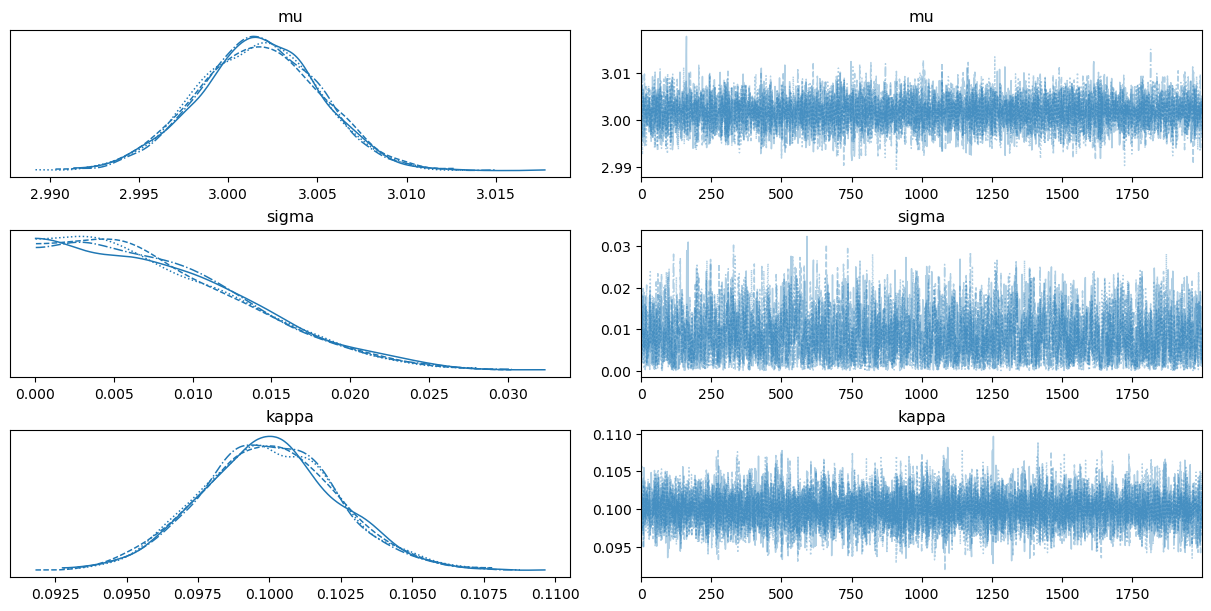

In [17]:
import arviz

arviz.plot_trace(mcmc, var_names=['mu', 'sigma', 'kappa'], backend_kwargs={'constrained_layout': True})

In [18]:
# visualize the predictive distribution

from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

rng_key, rng_key_ = random.split(rng_key)

pred = Predictive(model, mcmc.get_samples(), return_sites=["y"])
x_ = jnp.linspace(-3, 3, 1000)
predictions = pred(rng_key, x=x_, y=None)

mean_y = jnp.mean(predictions['y'], axis=0)
hpdi_y = hpdi(predictions['y'], 0.95)

plt.fill_between(x_, hpdi_y[0], hpdi_y[1], alpha=0.3, color='tab:blue')
plt.plot(x_, mean_y, lw=2, color='tab:red')
plt.plot(x, y, '+', markersize=12, color='tab:blue')
plt.xlabel('$x$', size=28)
plt.ylabel('$y$', size=28)
plt.tight_layout()

TypeError: model() got an unexpected keyword argument 'y'